<a href="https://colab.research.google.com/github/Marytem/Lane_detection/blob/master/unet_lane_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ideas&TODOs

* add augmentation

In [18]:
from google.colab import drive
drive.mount('/content/drive')   

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import model
from DataGenerator import DataGenerator

import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

### Data generation

In [0]:
NO_OF_EPOCHS = 40
BATCH_SIZE = 8

data_dir = '/content/drive/My Drive/lane data/segm_structure/'
train_generator = DataGenerator(data_dir+'train_fr/train/',
                                data_dir+'train_masks/train/',
                                batch_size=BATCH_SIZE)
val_generator = DataGenerator(data_dir+'val_fr/val/',
                              data_dir+'val_masks/val/',
                              batch_size=BATCH_SIZE)

### Define model

In [22]:
m = model.unet()
m.load_weights('Model.h5')
m.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

/content/model.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Train

In [0]:
NO_OF_EPOCHS = 40
BATCH_SIZE = 8

weights_path = 'weights/easy/'
checkpoint = ModelCheckpoint(weights_path, 
                             monitor='accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')
csv_logger = CSVLogger('./log.out',
                       append=True,
                       separator=';')
earlystopping = EarlyStopping(monitor ='accuracy',
                              verbose = 1,
                              min_delta = 0.01,
                              patience = 3,
                              mode = 'max')
callbacks_list = [checkpoint, csv_logger, earlystopping]
train_steps = math.ceil(len(train_generator) / train_generator.batch_size)
val_steps = math.ceil(len(val_generator) / val_generator.batch_size)

In [0]:
results = m.fit_generator(train_generator, 
                          epochs=NO_OF_EPOCHS, 
                          validation_data=val_generator, 
                          validation_steps=val_steps,
                          steps_per_epoch=train_steps,
                          )

### See results

===================BATCH_16===================


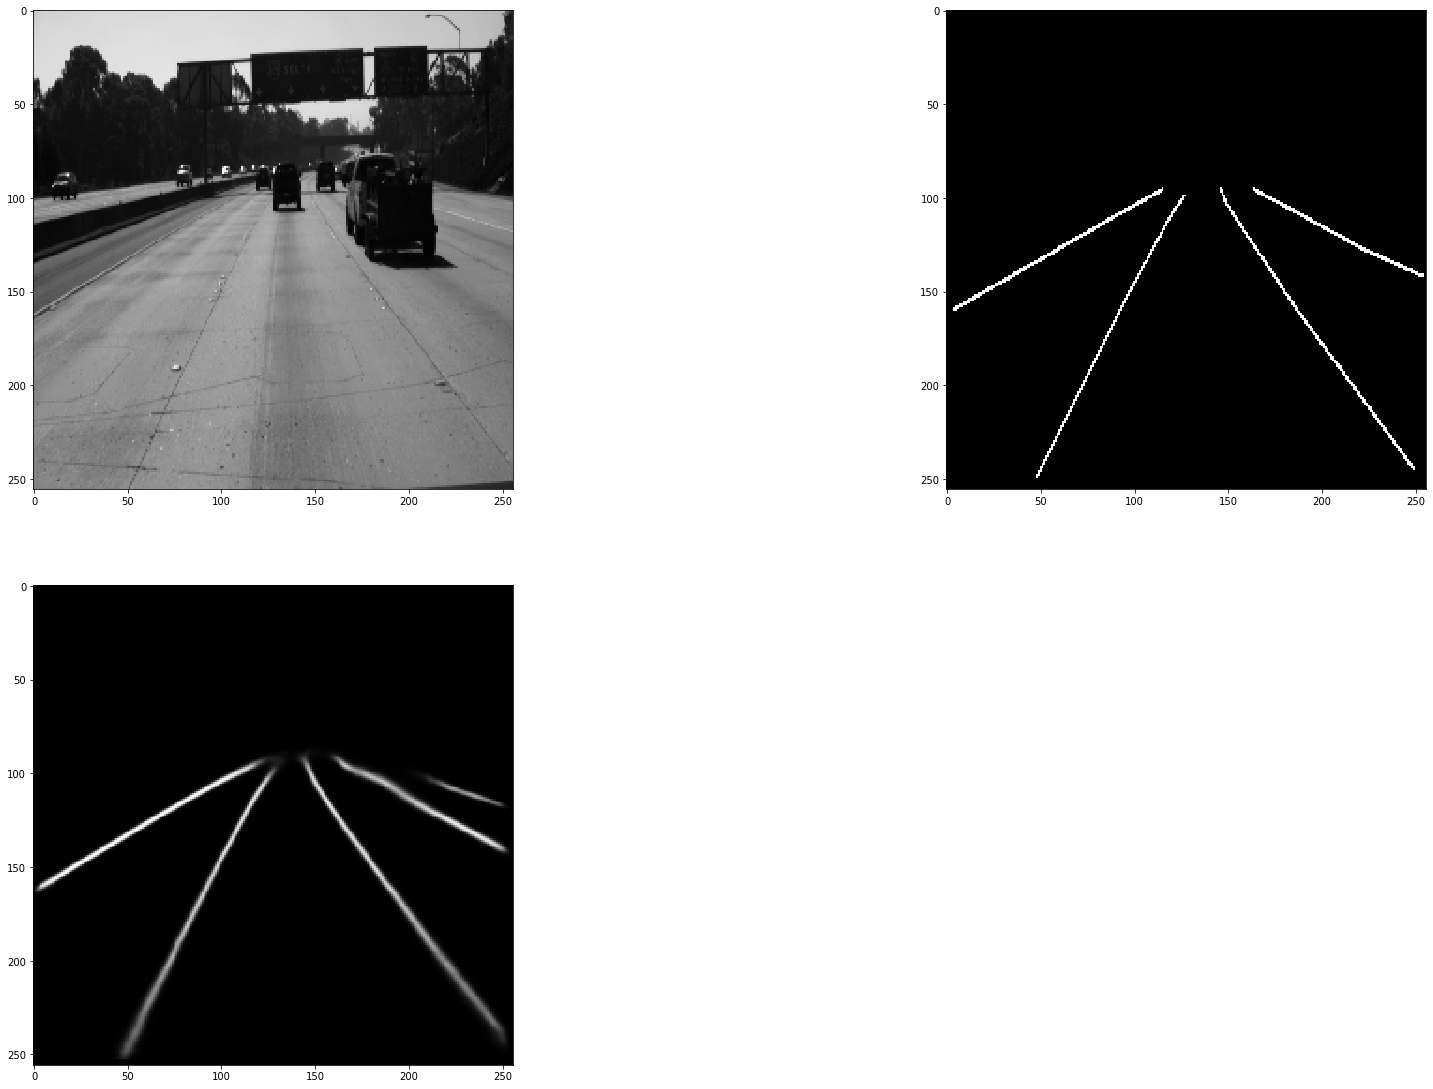

===================BATCH_4===================


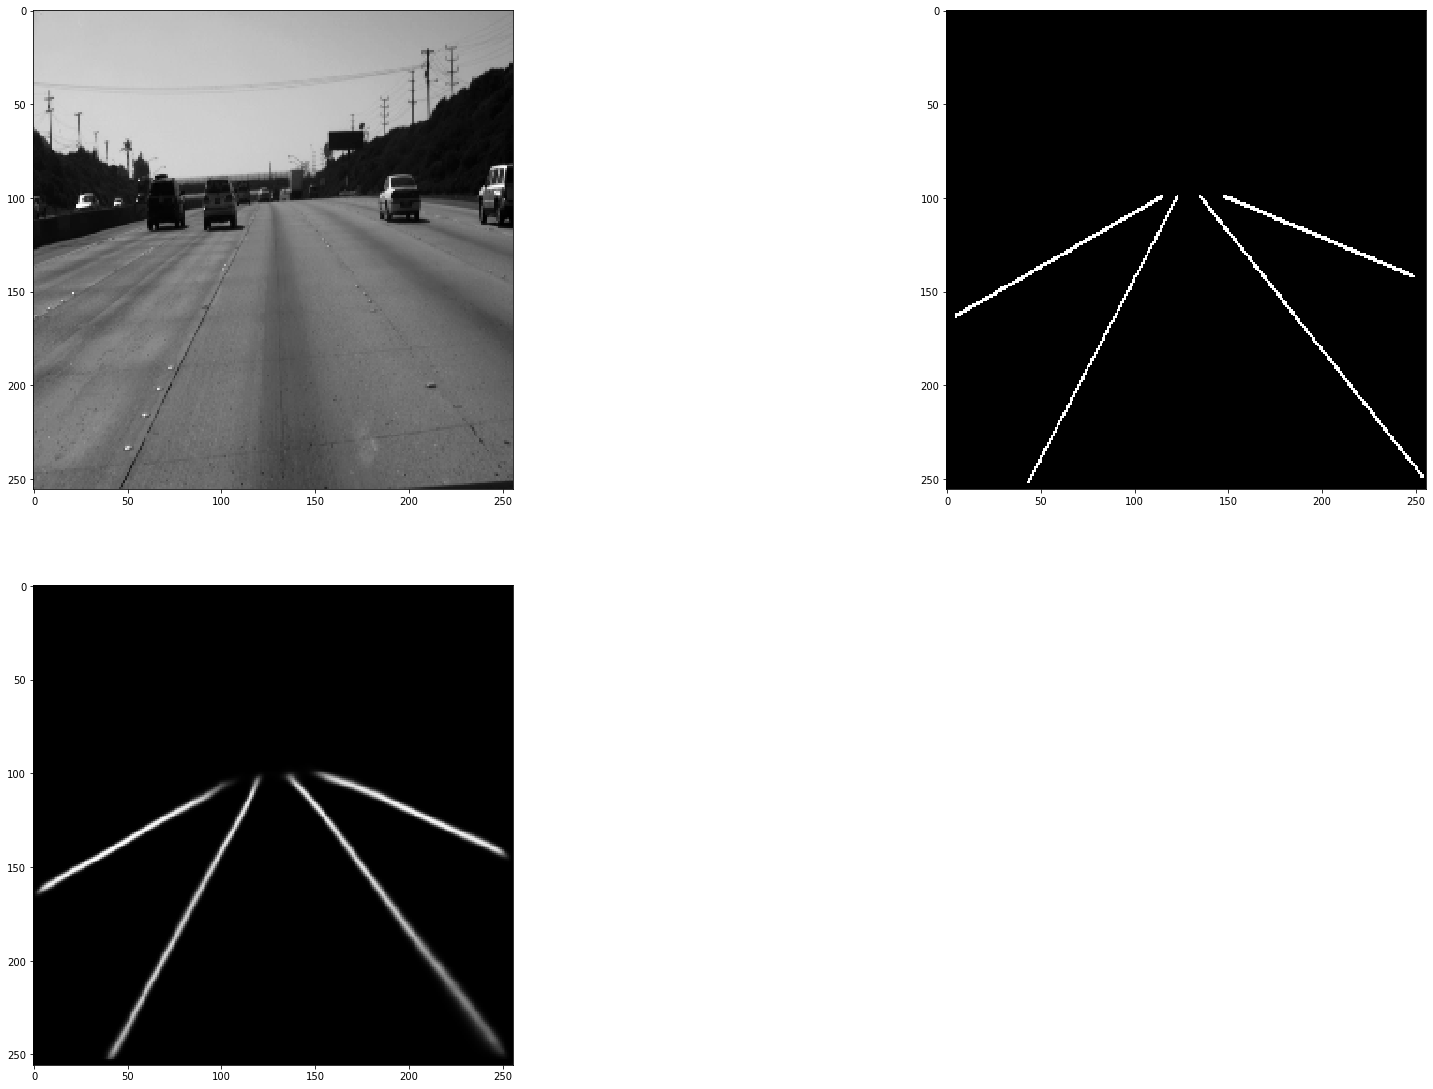

===================BATCH_23===================


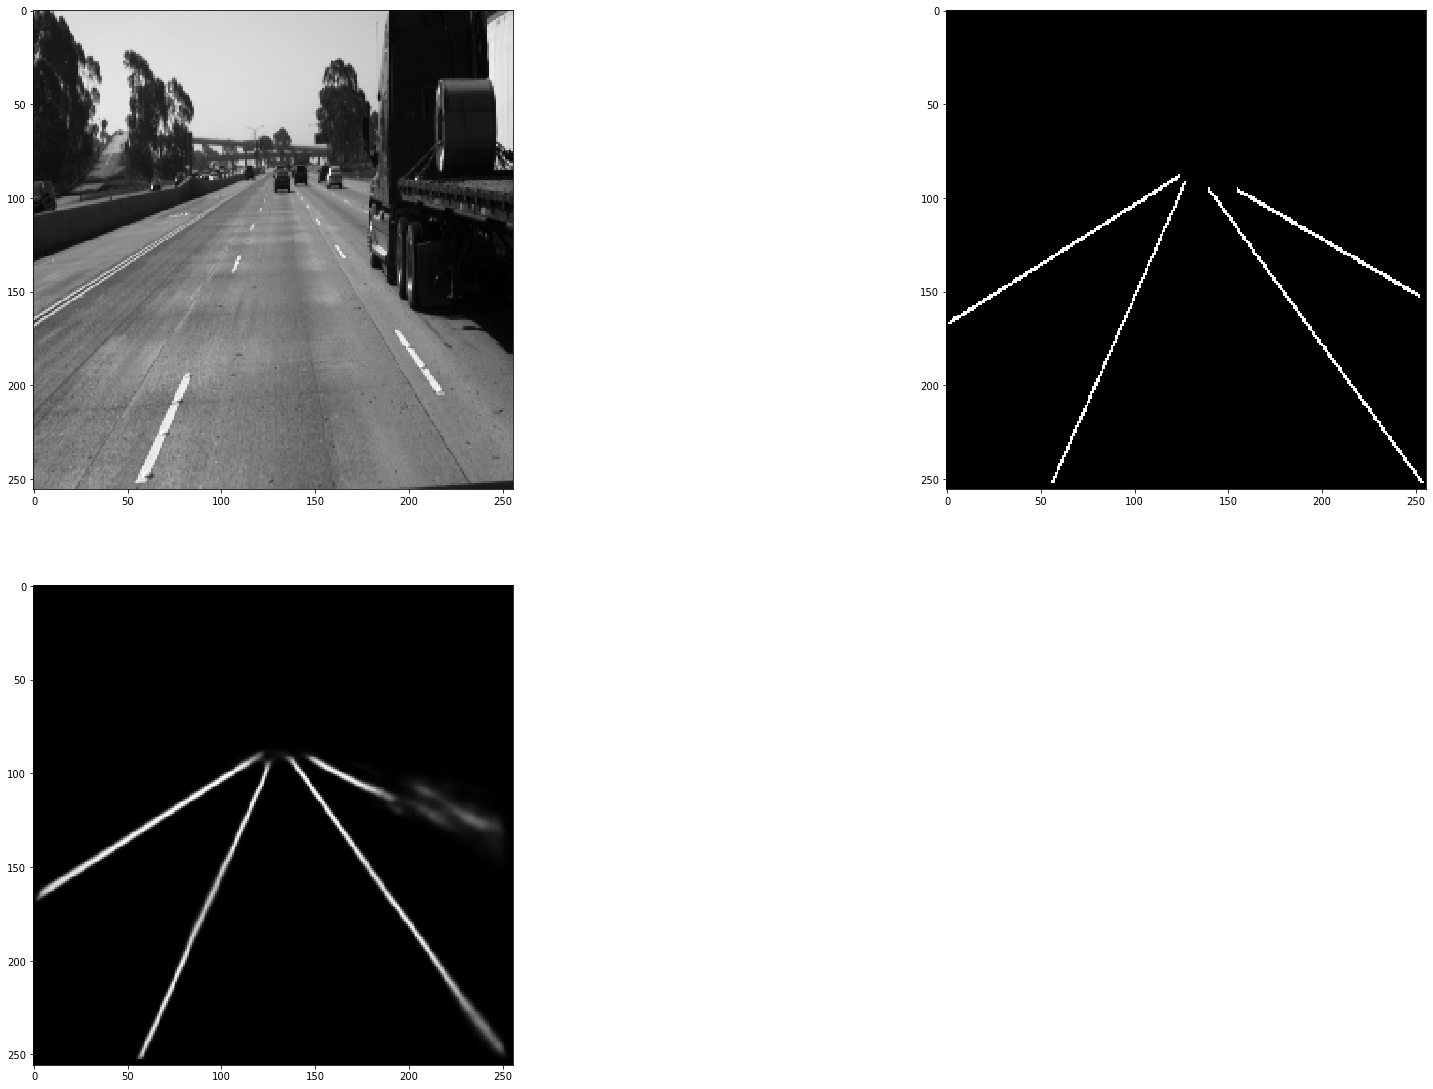

===================BATCH_34===================


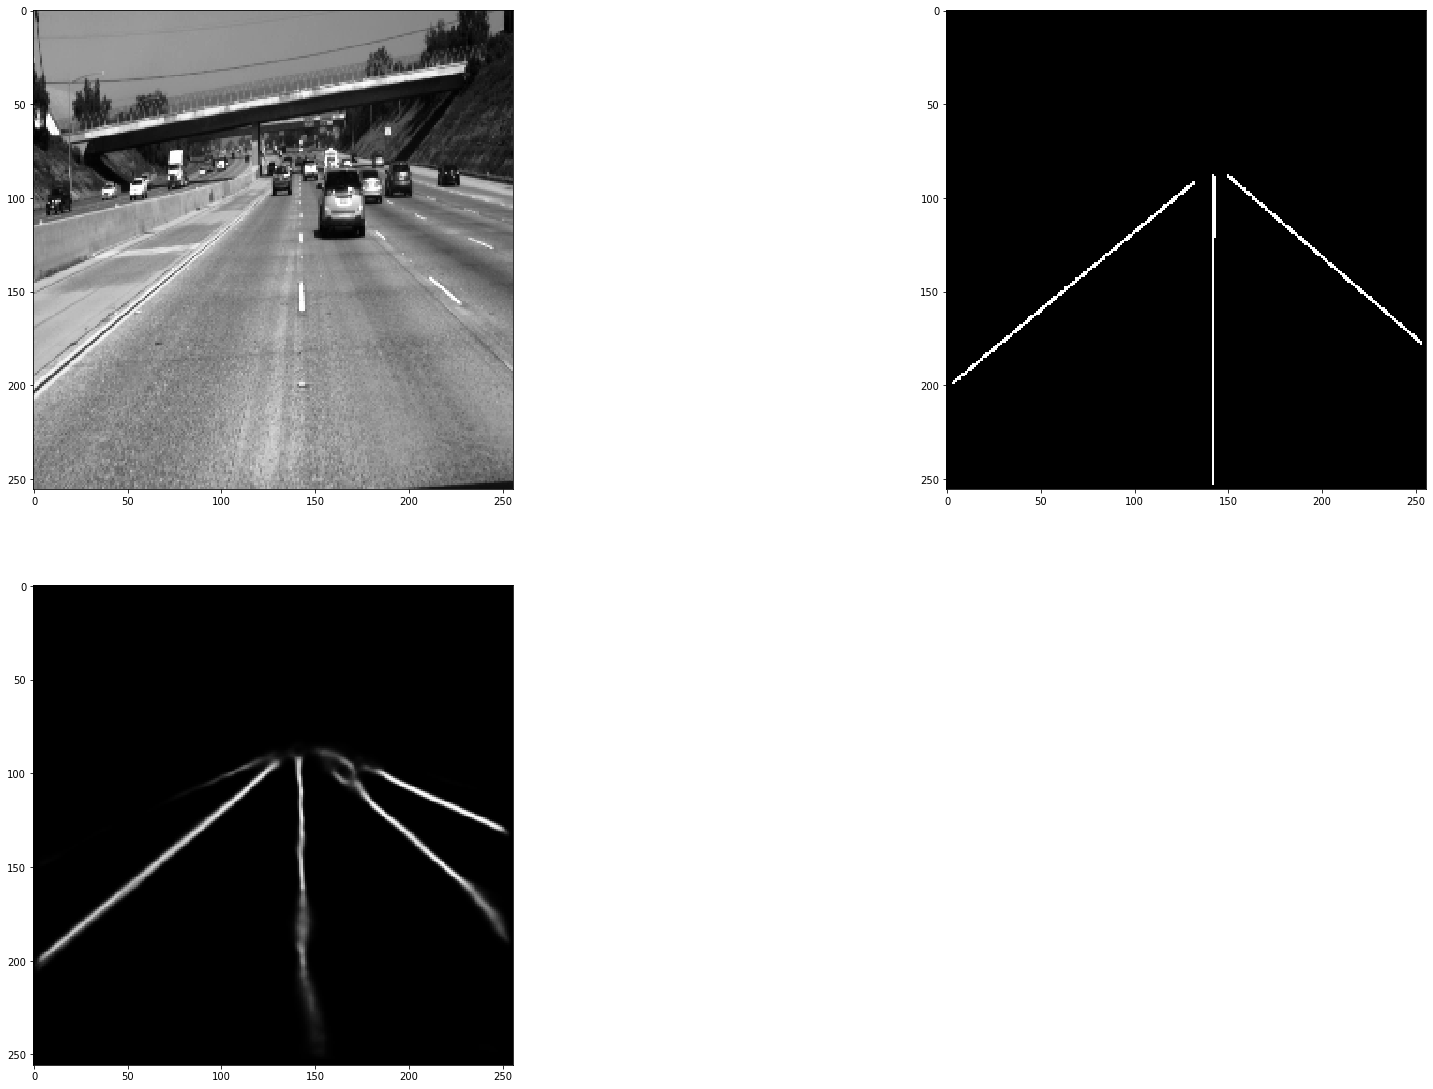

===================BATCH_44===================


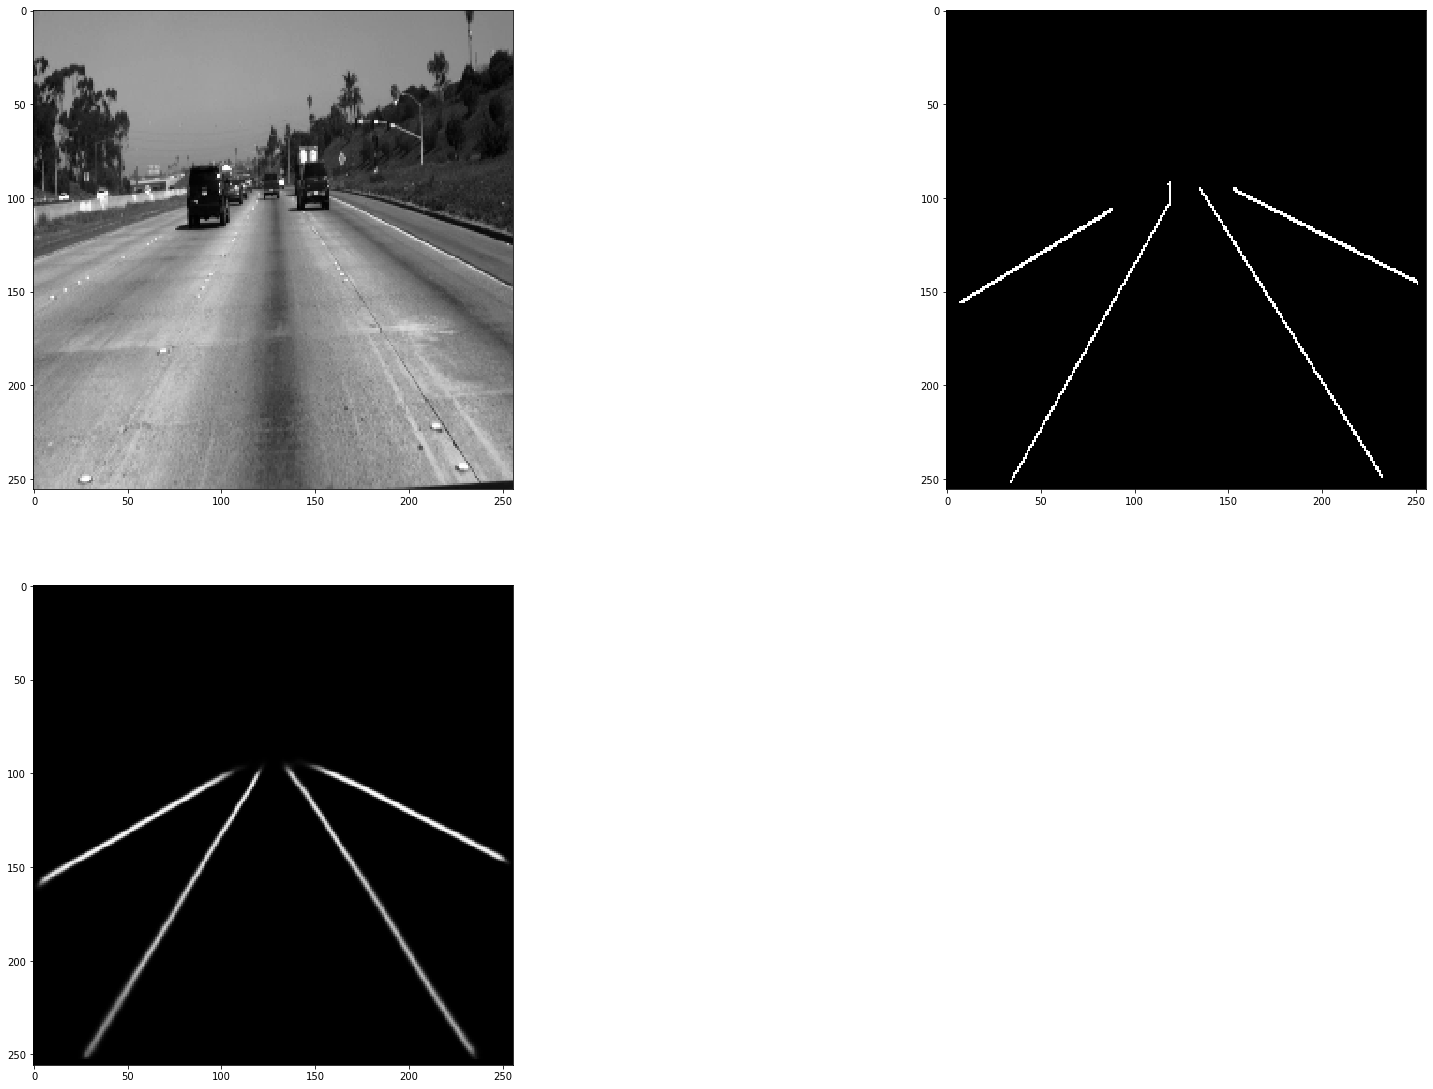

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
def display_images(images, cmap=None):
    plt.figure(figsize=(30,30))
    for i, image in enumerate(images):
        plt.subplot(3,2,i+1)
        plt.imshow(image, cmap)
        plt.autoscale(tight=True)
    plt.show()


batch_inds = [16, 4, 23, 34, 44]
for batch_ind in batch_inds:
    print('===================BATCH_{}==================='.format(batch_ind))
    pred = m.predict(val_generator[batch_ind][0])[3]
    img = val_generator[batch_ind][0][3]
    mask = val_generator[batch_ind][1][3]

    display_images([np.reshape(img, (256,256)),
                    np.reshape(mask, (256,256)), 
                    np.reshape(pred, (256,256))],
                cmap='Greys_r')
plt.show()

### Save model

In [0]:
m.save('Model.h5')